# Dispersive shift

The measurement of qubits in a quantum computer is needed to know anything about any experiment.

In this notebook, you will ...
* ... understand how the measurement signal depends on the state of the qubits.

By the end of this notebook, you will not only have a basic understanding of how to execute pulse schedules, but you will also have a feeling for the outcome to expect in your experiments.

In order to get started, make sure you have the appropriate packages installed:

In [ ]:
%%capture 
!pip install iqm-client
!pip install iqm-pulla 
!pip install matplotlib
!pip install pylatexenc

## 1. Preparation

### 1.1 Connecting to the QPU station control
In the following, we will use the PulLa (Pulse Level Access) package. You can find the documentation [here](https://docs.meetiqm.com/iqm-pulla/).

As a first step, we need to create a **PulLa object linked**. In general, this is a **compiler**, in a particular state, linked to a particular quantum computer. It contains calibration data and the set of available operations. 

Make sure you have the correct url and token below.

In [ ]:
from iqm.pulla.pulla import Pulla
import os
from iqm.iqm_client.authentication import TokenManager

# On-premise
#os.environ["IQM_TOKENS_FILE"]="your-token-here"
#p = Pulla("your-url-here", get_token_callback=TokenManager().get_bearer_token) 

#Resonance 
api_token = input()
p = Pulla("https://cocos.resonance.meetiqm.com/sirius", get_token_callback=lambda: api_token) 

compiler = p.get_standard_compiler()

## 2. Measurement operation

Qubit readout in superconducting systems is done via **superconducting resonators** (e.g. LC oscillators) that are coupled to the transmon qubits in the QPU. The coupling between the qubit and the resonator can be described with the [Jaynes-Cummings model](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model), which allows for two different regimes of the system, the **resonant** and the **dispersive** one. In the latter, looking at the spectrum of the resonator, one can infer the state of the qubit thanks to the **shift** in the resonator's frequency caused by the coupling. This shift is typically a few MHz.

The raw measurement signal is typically represented as a **complex number** as function of time. The measurement instrument integrates the signal over time to yield a complex number, one per measurement operation.

Knowing now that the readout signal depends on the state of the qubit, our strategy will be to prepare the qubits in different states and compare observations! 
1. Prepare a qubit in the $|0\rangle$ state and measure.
2. Prepare a qubit in the $|1\rangle$ state (applying an X gate) and measure.

Below we use the IQM Pulse syntax to define the circuits (you can find the documentation [here](https://docs.meetiqm.com/iqm-pulse/)).

In [2]:
from iqm.cpc.interface.compiler import Circuit, CircuitOperation as Op
import numpy as np

qubit = "QB1"
c0 = Circuit("0", [
    Op("measure", (qubit,), args={"key": "M"})    
])
c1 = Circuit("1", [
    Op("prx", (qubit,), args={"angle": np.pi, "phase": 0.0}),
    Op("measure", (qubit,), args={"key": "M"})    
])
circuits = [c0, c1]

### 2.1 Modify the calibration settings

To see the **dispersive shift effect**, we need to repeat the preparation and measurement protocol for different readout frequencies. This can be done by looking at the calibrated frequency and spanning a range of frequencies around this reference value. 

In [ ]:
f_0 =  compiler.get_calibration()[f"gates.measure.constant.{qubit}.frequency"]
f_axis = f_0 + np.linspace(-30e6, 30e6, 25) # in Hz

Additionally, we need to change the default calibration settings for the `measure` operation. In particular, we need to change the `acquisition_type` of the `constant` implementation from `threshold` to `complex`. 

For more details on this topic you can have a look at the Readout tutorial in the Tutorials page on IQM Academy :) 

Finally, we tweak the settings so that the shots used in the measurement are averaged by the server and we don't need to do it ourselves.
We are now ready to compile the circuits and run the experiment!

In [4]:
jobs = []
for f in f_axis:
    compiler.amend_calibration_for_gate_implementation(
        "measure", "constant", (qubit, ),
        {"acquisition_type": "complex", "frequency": f}
    )
    playlist, context = compiler.compile(circuits)
    settings, context = compiler.build_settings(context, shots=1000)
    settings.options.averaging_bins = 1  
    job = p.execute(playlist, context, settings, verbose=False)
    jobs.append(job)

[03-21 17:19:00;I] Submitted sweep with ID: bc192c2a-a4df-4e79-9a0f-bc7c07a2f509
[03-21 17:19:00;I] Created task in queue with ID: a6308bdb-409f-495a-b48b-f2f73a27b4a6
[03-21 17:19:00;I] Waiting for the sweep to finish...
[03-21 17:19:03;I] Sweep status: SweepStatus.SUCCESS
[03-21 17:19:03;I] Submitted sweep with ID: 99bb4539-56b2-48f9-ab99-f197b7285b28
[03-21 17:19:03;I] Created task in queue with ID: 8f0a89c3-c8a1-417b-9ea8-6e3d376f8615
[03-21 17:19:03;I] Waiting for the sweep to finish...
[03-21 17:19:06;I] Sweep status: SweepStatus.SUCCESS
[03-21 17:19:07;I] Submitted sweep with ID: f5a1dd7b-2b7c-4d24-9d62-f96db00aba4c
[03-21 17:19:07;I] Created task in queue with ID: 3120d376-a94f-48c5-8b1a-6d3667ac8614
[03-21 17:19:07;I] Waiting for the sweep to finish...
[03-21 17:19:10;I] Sweep status: SweepStatus.SUCCESS
[03-21 17:19:10;I] Submitted sweep with ID: 33562d89-4ee8-4695-a60d-6f91f80f5560
[03-21 17:19:10;I] Created task in queue with ID: f064691f-0317-4656-ad5b-90ba033893ce
[03-21 

## 3. Analyze the results

Now that the 'playlist' of instructions above has successfully run, we can extract the results and look at the readout signal as a function of frequency for the two different states. 

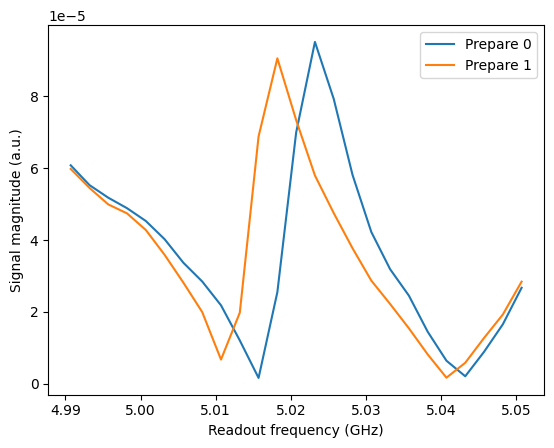

In [5]:
import matplotlib.pyplot as plt

state_0_results = np.array([job.result[0]["M"] for job in jobs]).squeeze()
state_1_results = np.array([job.result[1]["M"] for job in jobs]).squeeze()

plt.figure()
plt.plot(f_axis/1e9, np.abs(state_0_results), label="Prepare 0")
plt.plot(f_axis/1e9, np.abs(state_1_results), label="Prepare 1")
plt.xlabel("Readout frequency (GHz)")
plt.ylabel("Signal magnitude (a.u.)")
plt.legend();

We observe the dispersive shift effect: the qubit state shifts the spectrum of the resonator!

Now you know what happens behind the scenes everytime you append a measurement opeation to your circuit! We usually only monitor a fixed frequency and observe the change in magnitude and phase of the signal to return the result of a measurement. 

In [ ]:
# Copyright 2025 IQM Quantum Computers (Joni Ikonen, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.